In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df = pd.read_csv("sales_.csv", encoding="ISO-8859-1")

print("Dataset loaded successfully!")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Dataset loaded successfully!
Shape: (2823, 37)
Columns: ['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER', 'SALES', 'ORDERDATE', 'STATUS', 'QTR_ID', 'MONTH_ID', 'YEAR_ID', 'PRODUCTLINE', 'MSRP', 'PRODUCTCODE', 'CUSTOMERNAME', 'PHONE', 'ADDRESSLINE1', 'ADDRESSLINE2', 'CITY', 'STATE', 'POSTALCODE', 'COUNTRY', 'TERRITORY', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME', 'DEALSIZE', 'CATEGORY', 'SUBCATEGORY', 'USER_ID', 'SEASON', 'WEATHER', 'TEMPERATURE', 'TREND_SCORE', 'IS_EVENT_DAY', 'DISCOUNT_PERCENT', 'USER_AGE_GROUP', 'USER_GENDER', 'DEVICE_TYPE']


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,USER_ID,SEASON,WEATHER,TEMPERATURE,TREND_SCORE,IS_EVENT_DAY,DISCOUNT_PERCENT,USER_AGE_GROUP,USER_GENDER,DEVICE_TYPE
0,10107,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,...,U0001,Winter,Snowy,-2.4,0.623,0,1.8,41-60,Other,Mobile
1,10121,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,...,U0002,Spring,Mild,21.7,0.727,0,5.3,60+,Other,Desktop
2,10134,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,...,U0003,Summer,Dry,34.3,0.855,1,8.0,60+,Male,Desktop
3,10145,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,...,U0004,Summer,Dry,30.4,0.432,0,16.1,26-40,Male,Mobile
4,10159,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,...,U0005,Autumn,Cool,13.5,0.171,0,18.5,41-60,Female,Mobile


In [3]:
#Clean & encode data
# Converts into real dates
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'], errors='coerce')

# Handle missing values (if any)
df.fillna({
    "TEMPERATURE": df["TEMPERATURE"].mean(),
    "TREND_SCORE": df["TREND_SCORE"].mean(),
    "DISCOUNT_PERCENT": df["DISCOUNT_PERCENT"].mean()
}, inplace=True)

# Label encode categorical columns (numeric value ma change gareko)
categorical_cols = ['PRODUCTLINE', 'CATEGORY', 'SUBCATEGORY', 'DEALSIZE','COUNTRY', 'CITY', 'WEATHER', 'SEASON',
                    'USER_AGE_GROUP', 'USER_GENDER', 'DEVICE_TYPE']

label_encoders = {}
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [4]:
#Split into features and target
# Features affecting sales
feature_cols = ['PRODUCTLINE', 'CATEGORY', 'SUBCATEGORY', 'DEALSIZE','COUNTRY', 'CITY', 'WEATHER', 'SEASON', 'TEMPERATURE',
                'TREND_SCORE', 'IS_EVENT_DAY', 'DISCOUNT_PERCENT','USER_AGE_GROUP', 'USER_GENDER', 'DEVICE_TYPE']

X = df[feature_cols]
y = df['SALES']

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [5]:
#Train RandomForestRegressor (200 decission trees use garxa)
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Evaluate model
mse = mean_squared_error(y_test, y_pred) #small = better
r2 = r2_score(y_test, y_pred) #closer to 1 is better performance

print("\nModel Performance:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")



Model Performance:
Mean Squared Error (MSE): 1023907.79
R² Score: 0.77


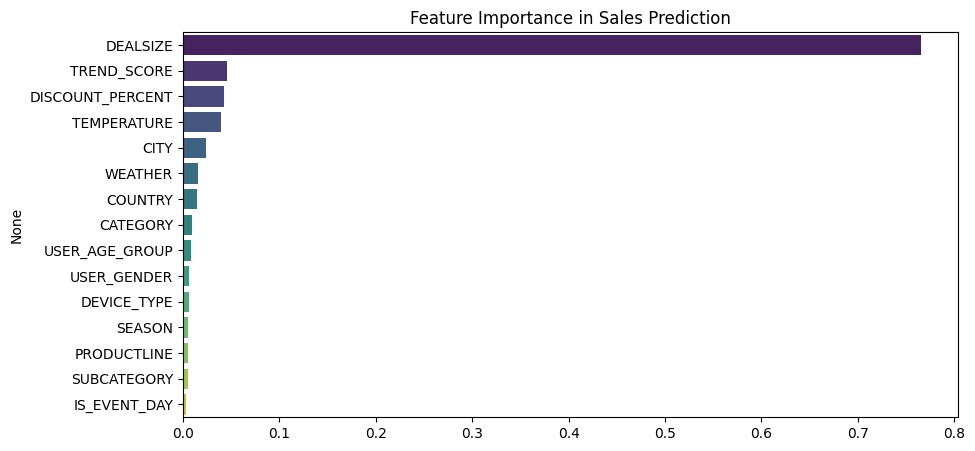

In [6]:
#Analyze Feature Importance
importances = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x=importances.values, y=importances.index, hue=importances.index,
            palette="viridis", legend=False)
plt.title("Feature Importance in Sales Prediction")
plt.show()  

In [7]:
# Example: Predict sales for a new situation
new_data = pd.DataFrame({
    'PRODUCTLINE': [1],
    'CATEGORY': [2],
    'SUBCATEGORY': [2],
    'DEALSIZE': [1],
    'COUNTRY': [5],
    'CITY': [10],
    'WEATHER': [3],
    'SEASON': [2],
    'TEMPERATURE': [28],
    'TREND_SCORE': [0.75],
    'IS_EVENT_DAY': [1],
    'DISCOUNT_PERCENT': [20],
    'USER_AGE_GROUP': [2],
    'USER_GENDER': [1],
    'DEVICE_TYPE': [0]
})

predicted_sales = model.predict(scaler.transform(new_data))
print(f"\nPredicted Future Sales (Sample Scenario): ${predicted_sales[0]:.2f}")



Predicted Future Sales (Sample Scenario): $4591.68


In [8]:
#recommend products based on feature similarity

# Create a product feature matrix
product_features = df.groupby('PRODUCTLINE')[['CATEGORY','SUBCATEGORY','SEASON','WEATHER','TREND_SCORE','DISCOUNT_PERCENT']].mean()

# Compute cosine similarity between product lines
similarity_matrix = cosine_similarity(product_features)
similarity_df = pd.DataFrame(similarity_matrix,index=product_features.index,columns=product_features.index)

# Function: Get top n similar products
def recommend_products(product_line, n=5):
    similar_items = similarity_df[product_line].sort_values(ascending=False)[1:n+1]
    return list(similar_items.index)

# Example recommendation
sample_product = df['PRODUCTLINE'].iloc[0]
recommended = recommend_products(sample_product)
print(f"\nRecommended Products similar to ProductLine '{sample_product}':")
print(recommended)



Recommended Products similar to ProductLine '1':
[0, 2, 3, 5, 4]


In [9]:
# Sales Trend by Month
df['MONTH'] = df['ORDERDATE'].dt.month
monthly_sales = df.groupby('MONTH')['SALES'].sum().reset_index()

fig = px.line(monthly_sales, x='MONTH', y='SALES',title='Monthly Sales Trend',markers=True, line_shape='spline')
fig.show()

# Sales by Weather Condition
fig = px.bar(df.groupby('WEATHER', as_index=False)['SALES'].sum(),
             x='WEATHER', y='SALES', title='Sales by Weather Condition',
             color='WEATHER')
fig.show()

# Top 10 Cities by Sales
top_cities = df.groupby('CITY')['SALES'].sum().nlargest(10).reset_index()
fig = px.bar(top_cities, x='CITY', y='SALES', title='Top 10 Cities by Sales',
             color='SALES', color_continuous_scale='Viridis')
fig.show()

# Sales by Gender
gender_sales = df.groupby('USER_GENDER', as_index=False)['SALES'].sum()
gender_map = dict(zip(label_encoders['USER_GENDER'].transform(label_encoders['USER_GENDER'].classes_), 
                      label_encoders['USER_GENDER'].classes_))
gender_sales['USER_GENDER'] = gender_sales['USER_GENDER'].map(gender_map)
fig = px.bar(gender_sales, x='USER_GENDER', y='SALES',
             title='Sales by Gender', color='SALES', color_continuous_scale='Viridis')
fig.show()

In [10]:
# Function: Recommend products popular for a specific gender
def recommend_by_gender(gender_code, top_n=5):
    # Filter purchases by this gender
    gender_df = df[df['USER_GENDER'] == gender_code]
    
    # Calculate average features for each product line for this gender
    gender_product_features = gender_df.groupby('PRODUCTLINE')[['CATEGORY','SUBCATEGORY','SEASON','WEATHER','TREND_SCORE','DISCOUNT_PERCENT']].mean()
    
    # Compute cosine similarity
    gender_similarity_matrix = cosine_similarity(gender_product_features)
    gender_similarity_df = pd.DataFrame(gender_similarity_matrix, index=gender_product_features.index, columns=gender_product_features.index)
    
    # Recommend top N similar products for the first product in this gender
    first_product = gender_product_features.index[0]
    similar_items = gender_similarity_df[first_product].sort_values(ascending=False)[1:top_n+1]
    return list(similar_items.index)

# Example usage: Recommend for Female (assuming encoded value = 1)
female_code = label_encoders['USER_GENDER'].transform(['Female'])[0]
female_recommendations = recommend_by_gender(female_code)
print(f"\nRecommended Products popular among Females:")
print(female_recommendations)


Recommended Products popular among Females:
[5, 1, 3, 4, 2]


In [11]:
def personalized_recommendations(product_line, user_gender=None, season=None, weather=None, top_n=5):
     # Start with the full dataset
    filtered_df = df.copy()
    
    # Apply optional filters
    if user_gender is not None:
        filtered_df = filtered_df[filtered_df['USER_GENDER'] == user_gender]
    if season is not None:
        filtered_df = filtered_df[filtered_df['SEASON'] == season]
    if weather is not None:
        filtered_df = filtered_df[filtered_df['WEATHER'] == weather]
    
    # Calculate average features for each product line in the filtered dataset
    if filtered_df.empty:
        print("No data for the selected filters. Showing overall recommendations.")
        filtered_df = df.copy()
        
    product_features_filtered = filtered_df.groupby('PRODUCTLINE')[['CATEGORY','SUBCATEGORY','SEASON','WEATHER','TREND_SCORE','DISCOUNT_PERCENT']].mean()
    
    # Compute cosine similarity
    similarity_matrix_filtered = cosine_similarity(product_features_filtered)
    similarity_df_filtered = pd.DataFrame(similarity_matrix_filtered, 
                                          index=product_features_filtered.index, 
                                          columns=product_features_filtered.index)
    
    # If the requested product_line is not in filtered_df (rare case), pick closest available
    if product_line not in similarity_df_filtered.index:
        product_line = similarity_df_filtered.index[0]
    
    # Get top N similar products
    similar_items = similarity_df_filtered[product_line].sort_values(ascending=False)[1:top_n+1]
    return list(similar_items.index)


# Decode gender name to code
female_code = label_encoders['USER_GENDER'].transform(['Female'])[0]

recommended_products = personalized_recommendations(
    product_line=df['PRODUCTLINE'].iloc[0],  # sample product
    user_gender=female_code,
    season=2,       # example: summer
    weather=3,      # example: sunny
    top_n=5
)

print(f"\nPersonalized Recommendations for Female, Summer, Sunny:")
print(recommended_products)


No data for the selected filters. Showing overall recommendations.

Personalized Recommendations for Female, Summer, Sunny:
[0, 2, 3, 5, 4]
